In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [10]:
air_df = pd.read_csv('final_air_quality.csv')
air_df.head()

,Dist_ID,District,Name,Prov_ID,Province,Sect_ID,NO2_mean,year,month,date,CO_mean,SO2_mean,O3_mean,AER_mean,CH4_mean,poor_percent,avg_deprivation_intensity,poverty_index
0,11,Nyarugenge,Gitega,1,Kigali City,1101,0.000041,2020,1,2020-01,0.038910,-4.553785e-05,0.111056,-1.252367,NaN,0.025,0.394,0.010
1,11,Nyarugenge,Gitega,1,Kigali City,1101,0.000039,2020,2,2020-02,0.034758,-6.027024e-07,0.113404,-1.377423,NaN,0.157,0.410,0.065
2,11,Nyarugenge,Gitega,1,Kigali City,1101,0.000038,2020,3,2020-03,0.035565,1.019581e-05,0.116727,-1.524711,NaN,0.143,0.411,0.059
3,11,Nyarugenge,Gitega,1,Kigali City,1101,0.000038,2020,4,2020-04,0.031162,3.465083e-04,0.116457,-1.392731,NaN,0.039,0.398,0.015
4,11,Nyarugenge,Gitega,1,Kigali City,1101,0.000043,2020,5,2020-05,0.027599,4.715642e-05,0.114809,-1.535792,NaN,0.250,0.426,0.107


In [11]:
air_df = air_df.drop(columns=['CH4_mean'])
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25376 entries, 0 to 25375
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Dist_ID                    25376 non-null  int64  
 1   District                   25376 non-null  object 
 2   Name                       25376 non-null  object 
 3   Prov_ID                    25376 non-null  int64  
 4   Province                   25376 non-null  object 
 5   Sect_ID                    25376 non-null  int64  
 6   NO2_mean                   25376 non-null  float64
 7   year                       25376 non-null  int64  
 8   month                      25376 non-null  int64  
 9   date                       25376 non-null  object 
 10  CO_mean                    25376 non-null  float64
 11  SO2_mean                   25352 non-null  float64
 12  O3_mean                    25376 non-null  float64
 13  AER_mean                   25376 non-null  flo

In [12]:
scaler = StandardScaler()
air_df[["NO2_mean", "SO2_mean", "O3_mean", "CO_mean", "AER_mean"]] = scaler.fit_transform(
    air_df[["NO2_mean", "SO2_mean", "O3_mean", "CO_mean", "AER_mean"]]
)

In [13]:
scale_height = 8000
molar_masses = {
    "NO2": 46.01,
    "CO": 28.01,
    "SO2": 64.07,
    "O3": 48.00
}
who_limits = {
    "NO2": 10,  # µg/m³
    "CO": 4,  # mg/m³
    "SO2": 40,  # µg/m³
    "O3": 60  # µg/m³
}

for gas in ["NO2_mean", "SO2_mean", "O3_mean"]:
  gas_name = gas.replace("_mean", "")
  air_df[gas_name + "_µg_m3"] = (air_df[gas] * molar_masses[gas_name]) / scale_height

air_df["CO_mg_m3"] = (air_df["CO_mean"] * molar_masses["CO"]) / scale_height

# Compute Exceedance Factor (EF)
for gas in who_limits:
  if gas != 'CO':
    air_df[gas + "_EF"] = air_df[gas + "_µg_m3"] / who_limits[gas]
  else:
    air_df[gas + "_EF"] = air_df[gas + "_mg_m3"] / who_limits[gas]

# Handle AER
air_df["AER_EF"] = (air_df["AER_mean"] - air_df["AER_mean"].min()) / (air_df["AER_mean"].max() - air_df["AER_mean"].min())

# Compute AQI (Max Exceedance Approach)
air_df["AQI"] = air_df[["NO2_EF", "CO_EF", "SO2_EF", "O3_EF", "AER_EF"]].max(axis=1) * 100

# Save to CSV
air_df.to_csv("AQI_calculated.csv", index=False)

In [14]:
correlation = air_df['AQI'].corr(air_df['poverty_index'])

print(f"Correlation between A and B: {correlation}")

Correlation between A and B: 0.16506930746581033


Correlation coefficient ●• 0.17


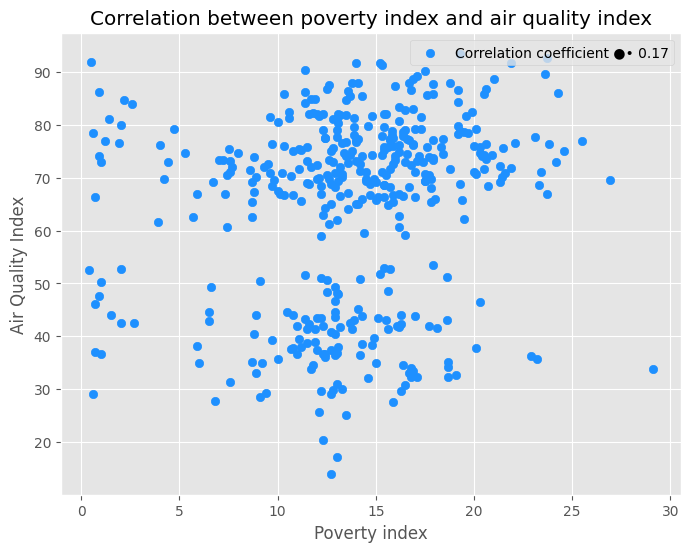

In [31]:
plt.figure(figsize=(8, 6))

# set nice plt config style
plt.style.use('ggplot')

# use dejavu font
plt.rcParams['font.family'] = 'DejaVu Sans'

# multiplied = air_df['AQI'] * 100

plt.scatter(air_df['poverty_index'] * 100, air_df['AQI'], color='dodgerblue')


correlation_coefficient = air_df['poverty_index'].corr(air_df['AQI'])
# take only 2 decimal places
correlation_coefficient = round(correlation_coefficient, 2)
print(f"Correlation coefficient ●• {correlation_coefficient}")

# add correlation coefficient to plot as legend
plt.legend(
    [f"Correlation coefficient ●• {correlation_coefficient}"], loc='upper right')

# add a trendline
# z = np.polyfit(air_df['poverty_index'] * 100, air_df['AQI'], 1)
# p = np.poly1d(z)
# plt.plot(air_df['poverty_index'] * 100, p(air_df['poverty_index'] * 100), color='red')

# print correlation coefficient
# plt.text(0.5, 0.5, f"Correlation coefficient: {correlation_coefficient}", color='red', fontsize=12, transform=plt.gca().transAxes)

# Adding labels and title

plt.xlabel('Poverty index')

plt.ylabel('Air Quality Index')

plt.title('Correlation between poverty index and air quality index')


# Show grid and legend

plt.grid(True)


# Show plot

plt.show()